# Выпускной проект "телекоммуникации"

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Загрузка данных

Начинаем с импорта необходимых библиотек.

In [1]:
# Загрузка библиотек:
!pip install -U pyodbc -q

!pip install -U numpy -q
!pip install -U pandas -q 
!pip install -U scikit-learn -q

!pip3 install phik -q
!pip3 install imblearn -q
!pip3 install catboost -q
!pip3 install lightgbm -q

!pip3 install pytest -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.0 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [2]:
# Добавление нужных библиотек:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder 

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE 

from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score

import phik
from phik.report import plot_correlation_matrix

import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

In [3]:
# Глобальные переменные:
RANDOM_STATE = 30624
TEST_SIZE = 0.25

Переходим к распаковке данных. Всего имеем 4 файла; загрузим их, посмотрим общие сведения.

In [4]:
# Загрузка данных:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

display(contract.head())
contract.info()
print('-----')
display(personal.head())
personal.info()
print('-----')
display(internet.head())
internet.info()
print('-----')
display(phone.head())
phone.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
-----


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
-----


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
-----


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В основном в таблицах находятся категориальные переменные, общим является столбец с номером абонента. Пропусков не наблюдается, название стоблцов корректное, можно не править, уже хорошо, вот только количество строк во всех таблицах разное. Возможно, информация есть не по всем пользователям. Проверим количество уникальных id в самой большой таблице.

In [5]:
# Количество уникальных id:
print('Уникальных id:', len(pd.unique(contract['customerID'])))

Уникальных id: 7043


Получается, каких-то пользователей не успели охарактеризовать в других таблицах.

### Промежуточный вывод:
Загрузили исходные файлы с данными; пропусков в них не обнаружено, однако сразу столкнулись с проблемой нехватки информации по некоторым пользователям. Придётся серьёзно урезать количество данных.

## Предобработка данных

Далее обработаем все таблицы в итоговую и обработаем её: разберёмся с типами данных, проверим на корректное заполнение, возможно, изменим названия столбцов.

In [6]:
# Объединение таблиц:
df = contract.merge(personal, on='customerID', how='inner')
df = df.merge(internet, on ='customerID', how = 'outer')
df = df.merge(phone, on ='customerID', how = 'outer')

display(df.head())
df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.1,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.0,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [7]:
# Проверка на дубликаты:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


Дубликатов не обнаружено. Надо придумать, как заменить пустые значения в столбцах; удалять данные нельзя, так как их мало. 
Из общего обзора знаем, что некоторые пользуются либо телефоном, либо интернетом. Заполним пропуски, исходя из этой информации.

In [8]:
# Выделим столбцы:
without_int = ['MultipleLines']
without_tel = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Заполним пробелы:
df[without_int] = df[without_int].fillna('WI')
df[without_tel] = df[without_tel].fillna('WT')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


С пропусками разобрались, теперь добавим целевой признак. Точнее он у нас уже есть, это EndDate: если есть дата, клиент ушёл, первая категория; если No - нулевая категория.

In [9]:
# Функция для преобразования:
def target_maker(row):
    if row['EndDate'] == 'No':
        return 0
    return 1

df['target'] = df.apply(target_maker, axis=1)
display(df.sample(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
3909,5499-ECUTN,2016-03-01,2018-01-01,One year,Yes,Credit card (automatic),66.05,1525.75,Female,0,...,No,DSL,Yes,No,Yes,No,Yes,No,No,1
4953,6974-DAFLI,2015-07-01,No,One year,No,Electronic check,19.70,1083.5,Female,0,...,No,WT,WT,WT,WT,WT,WT,WT,No,0
6681,9497-QCMMS,2019-12-01,No,Month-to-month,Yes,Electronic check,93.55,196.46,Male,1,...,No,Fiber optic,No,No,No,No,Yes,Yes,Yes,0
1645,2388-LAESQ,2014-02-01,No,Two year,Yes,Bank transfer (automatic),114.85,8765.35,Female,1,...,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
1938,2812-REYAT,2016-01-01,No,One year,Yes,Bank transfer (automatic),20.05,1070.87,Female,0,...,No,WT,WT,WT,WT,WT,WT,WT,No,0
1927,2801-NISEI,2018-02-01,No,Month-to-month,No,Electronic check,54.95,1371.55,Male,0,...,No,DSL,Yes,No,No,Yes,No,No,No,0
3053,4369-HTUIF,2019-07-01,No,Month-to-month,Yes,Bank transfer (automatic),85.15,596.05,Male,1,...,No,Fiber optic,Yes,No,No,No,Yes,No,No,0
5896,8294-UIMBA,2017-08-01,No,One year,Yes,Bank transfer (automatic),94.40,2832.0,Female,0,...,No,Fiber optic,No,No,No,Yes,Yes,Yes,No,0
2954,4213-HKBJO,2017-05-01,No,Two year,No,Credit card (automatic),25.70,856.58,Female,0,...,No,WT,WT,WT,WT,WT,WT,WT,Yes,0
2605,3717-LNXKW,2016-12-01,No,Month-to-month,No,Bank transfer (automatic),91.70,3484.6,Male,0,...,No,Fiber optic,Yes,No,No,No,Yes,No,Yes,0


In [10]:
#КОД МЕНТОРА

df.target.value_counts()

target
0    5942
1    1101
Name: count, dtype: int64

Из подсказки понятно, что необходим новый столбец - продолжительность пользования услугами.

In [11]:
# Создание нового признака: 
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

df['EndDate'] = df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

df['duration_cont'] = (df['EndDate'] - df['BeginDate']).dt.days

display(df.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration_cont
0,0002-ORFBO,2019-05-01,2020-02-01,One year,Yes,Mailed check,65.6,631.73,Female,0,...,DSL,No,Yes,No,Yes,Yes,No,No,0,276
1,0003-MKNFE,2019-05-01,2020-02-01,Month-to-month,No,Mailed check,59.9,539.1,Male,0,...,DSL,No,No,No,No,No,Yes,Yes,0,276
2,0004-TLHLJ,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,...,Fiber optic,No,No,Yes,No,No,No,No,0,153


Теперь посмотрим корректность записи всех данных.

In [12]:
# Анализ уникальных значений:
for i in df.columns:
    print(f'Признак "{i}" имеет {len(df[i].unique())} уникальных значений:')
    print(df[i].unique(), '\n')

Признак "customerID" имеет 7043 уникальных значений:
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH'] 

Признак "BeginDate" имеет 77 уникальных значений:
<DatetimeArray>
['2019-05-01 00:00:00', '2019-09-01 00:00:00', '2018-12-01 00:00:00',
 '2014-03-01 00:00:00', '2014-11-01 00:00:00', '2019-07-01 00:00:00',
 '2014-09-01 00:00:00', '2015-08-01 00:00:00', '2014-02-01 00:00:00',
 '2015-06-01 00:00:00', '2017-04-01 00:00:00', '2020-01-01 00:00:00',
 '2016-03-01 00:00:00', '2019-10-01 00:00:00', '2015-12-01 00:00:00',
 '2018-10-01 00:00:00', '2018-03-01 00:00:00', '2019-11-01 00:00:00',
 '2015-07-01 00:00:00', '2017-12-01 00:00:00', '2014-05-01 00:00:00',
 '2017-01-01 00:00:00', '2016-01-01 00:00:00', '2014-08-01 00:00:00',
 '2014-07-01 00:00:00', '2018-06-01 00:00:00', '2016-07-01 00:00:00',
 '2015-03-01 00:00:00', '2019-02-01 00:00:00', '2017-11-01 00:00:00',
 '2018-01-01 00:00:00', '2017-09-01 00:00:00', '2017-03-01 00:00:00',
 '2014-10-01 00:00:00', 

Также из подсказки стало понятно, что в столбце "TotalCharges" есть пробелы. Заменим их на None и далее удалим эти строки.

In [13]:
# Поиск ошибок:
def maker(row):
    if row['TotalCharges'] == ' ':
        return None
    return row

df = df.apply(maker, axis=1)

# Изменим тип данных:
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [14]:
# Удаляем все излишки:
del df['BeginDate']
del df['EndDate'] 
del df['customerID']

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   float64
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 
 17  

In [15]:
# Изменим типы данных некоторых столбцов:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int64')
df['target'] = df['target'].astype('int64')
df['duration_cont'] = df['duration_cont'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 
 17  

### Промежуточный вывод:
Произведена предобработка данных, в ходе которой были совершены следующие действия:
  - объединены исходные датафреймы;
  - произведена проверка на дубликаты;
  - обработаны типы данных;
  - заполнены пропуски;
  - добавлены новые признаки;
  - удалены лишние столбцы.

## Исследовательский анализ данных

Задача не про анализ данных, но минимальное ознакомление с ними и поиск общих закономерностей необходимы.

Прежде всего нас интересует корреляция целевого признака с остальными. Корреляция Пирсона не подойдёт, будем использовать Фи.

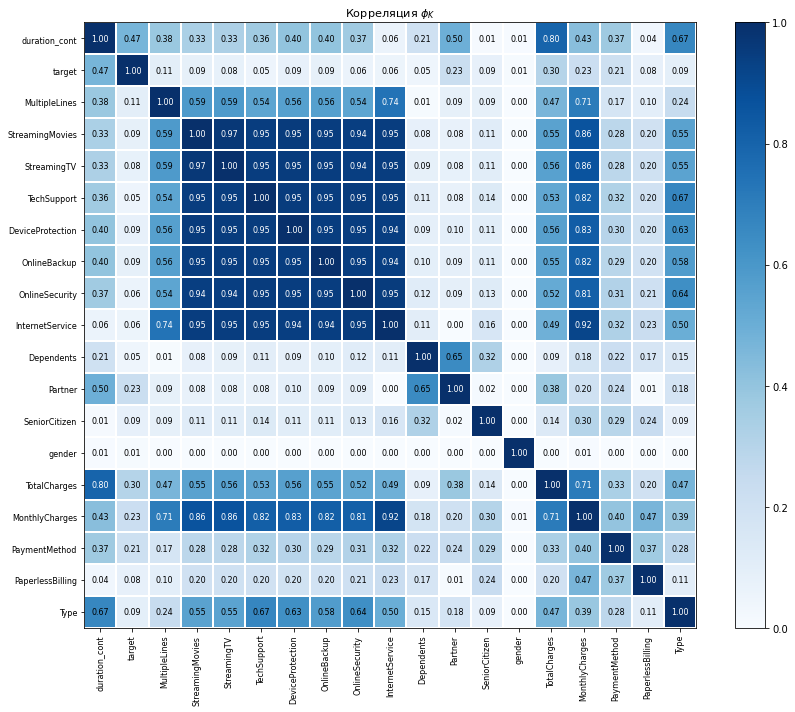

In [16]:
# Подготовка матрицы корреляции:
phik_overview = df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'duration_cont'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

Видим, что многие признаки имеют очень слабую связь с целевым. Построим графики зависимостей и рассмотрим их подробнее.

Распределение значений признака "Type"


,count,unique,top,freq
Класс 0,5931,3,Month-to-month,3468
Класс 1,1101,3,Month-to-month,407


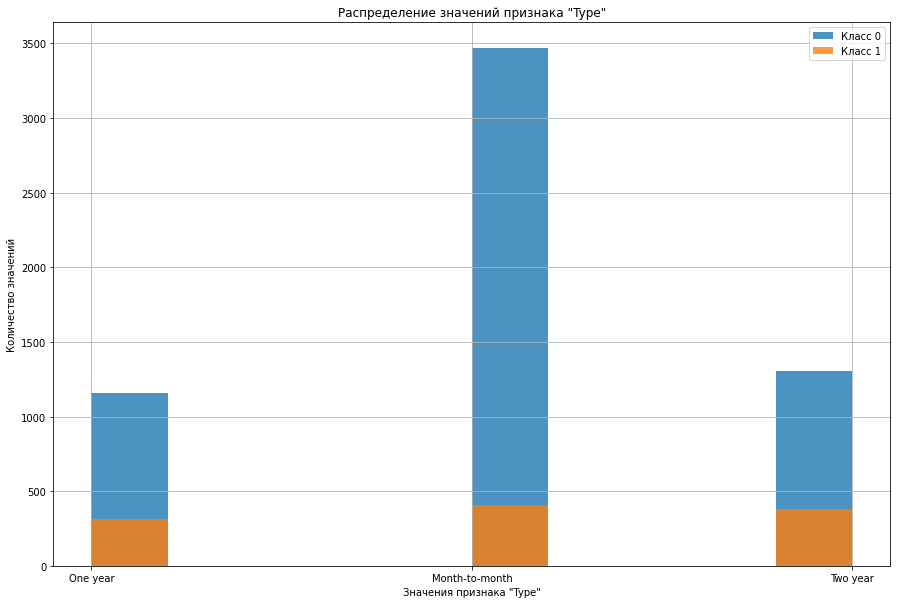

Распределение значений признака "PaperlessBilling"


,count,unique,top,freq
Класс 0,5931,2,Yes,3447
Класс 1,1101,2,Yes,721


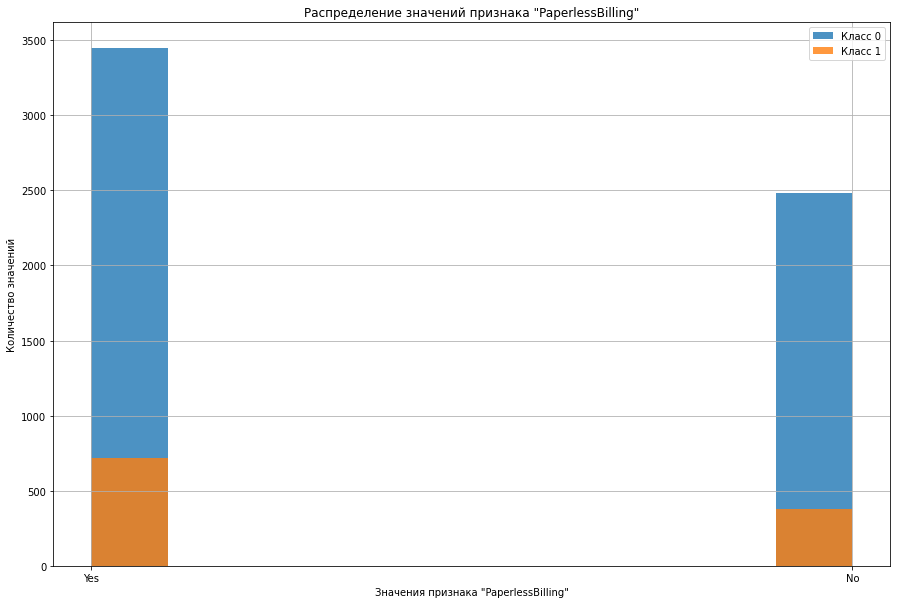

Распределение значений признака "PaymentMethod"


,count,unique,top,freq
Класс 0,5931,4,Electronic check,2015
Класс 1,1101,4,Electronic check,350


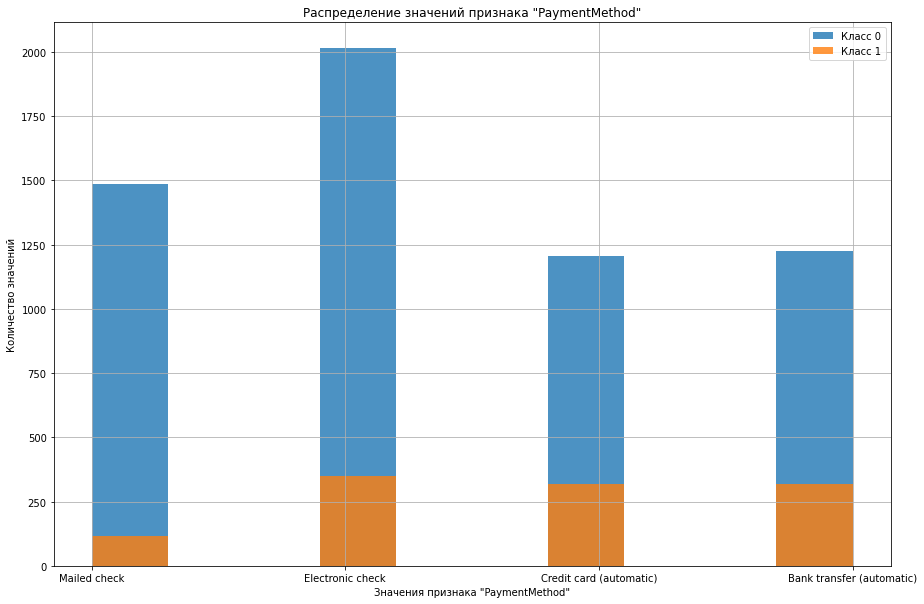

Распределение значений признака "MonthlyCharges"


,count,mean,std,min,25%,50%,75%,max
Класс 0,5931.0,62.803043,29.841911,18.25,30.125,69.25,87.325,118.60
Класс 1,1101.0,75.546004,29.116213,18.40,56.150,84.20,99.500,118.75


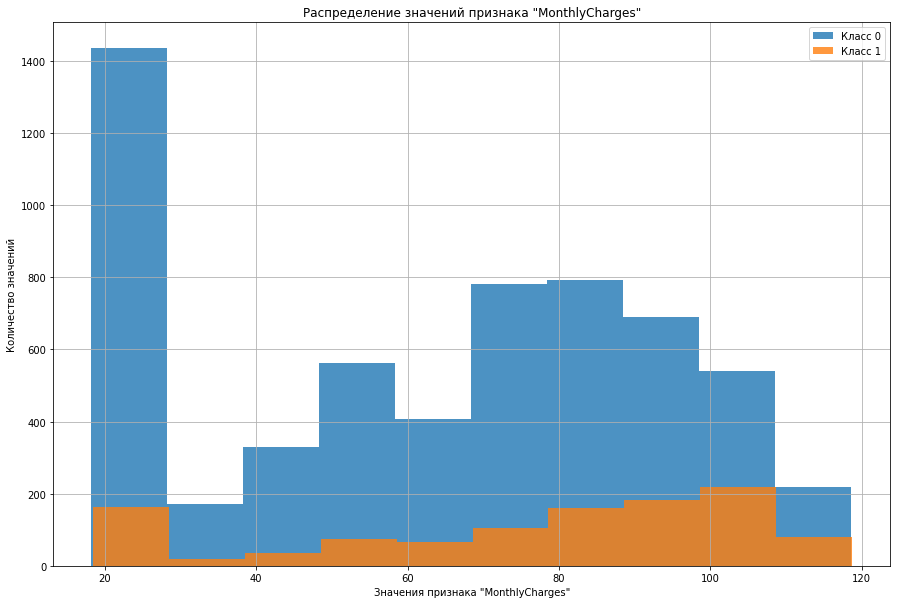

Распределение значений признака "TotalCharges"


,count,mean,std,min,25%,50%,75%,max
Класс 0,5931.0,2071.701614,2194.122190,19.05,376.225,1194.28,3176.00,9221.38
Класс 1,1101.0,2371.377275,1581.862275,77.84,1048.050,2139.03,3404.91,7649.76


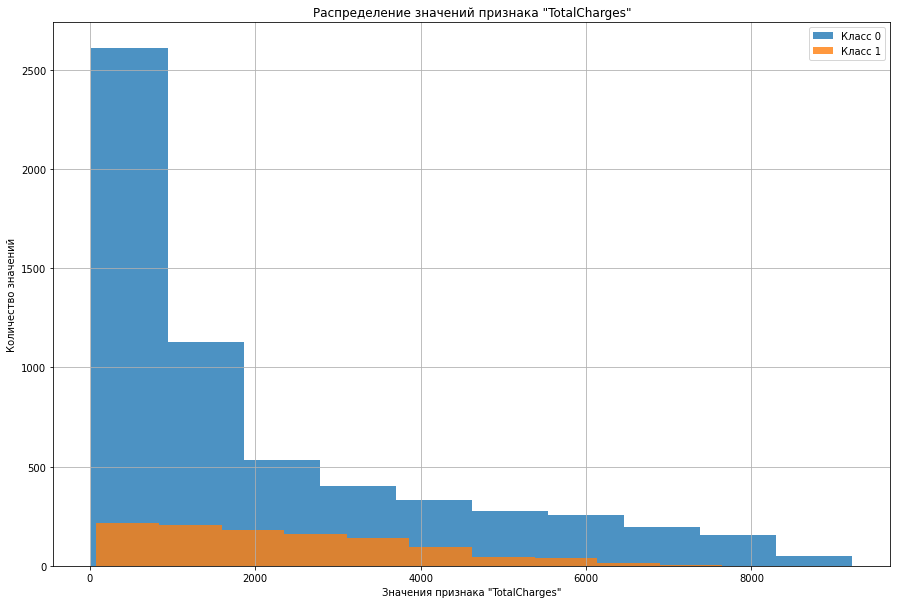

Распределение значений признака "gender"


,count,unique,top,freq
Класс 0,5931,2,Male,2976
Класс 1,1101,2,Male,573


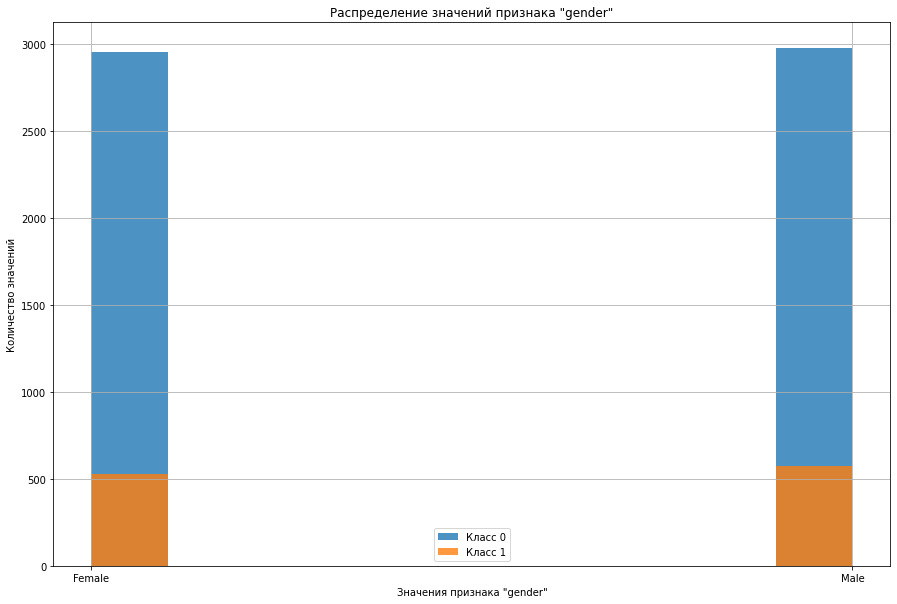

Распределение значений признака "SeniorCitizen"


,count,mean,std,min,25%,50%,75%,max
Класс 0,5931.0,0.153431,0.360433,0.0,0.0,0.0,0.0,1.0
Класс 1,1101.0,0.210718,0.408003,0.0,0.0,0.0,0.0,1.0


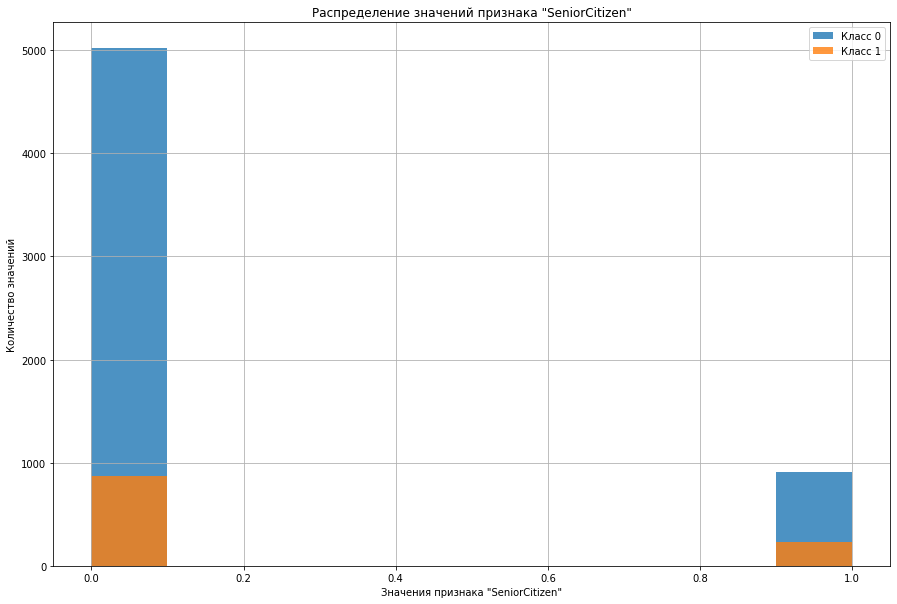

Распределение значений признака "Partner"


,count,unique,top,freq
Класс 0,5931,2,No,3257
Класс 1,1101,2,Yes,719


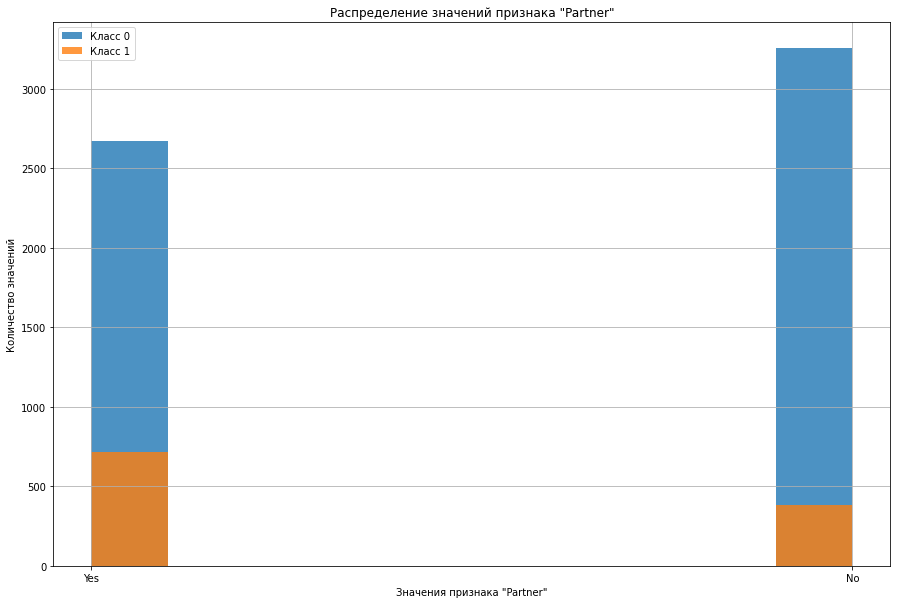

Распределение значений признака "Dependents"


,count,unique,top,freq
Класс 0,5931,2,No,4200
Класс 1,1101,2,No,733


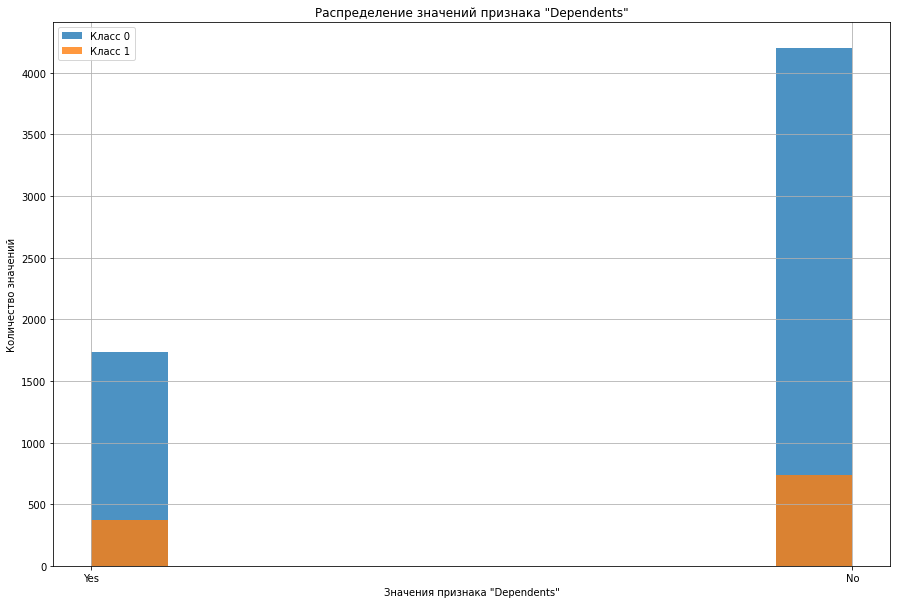

Распределение значений признака "InternetService"


,count,unique,top,freq
Класс 0,5931,3,Fiber optic,2501
Класс 1,1101,3,Fiber optic,595


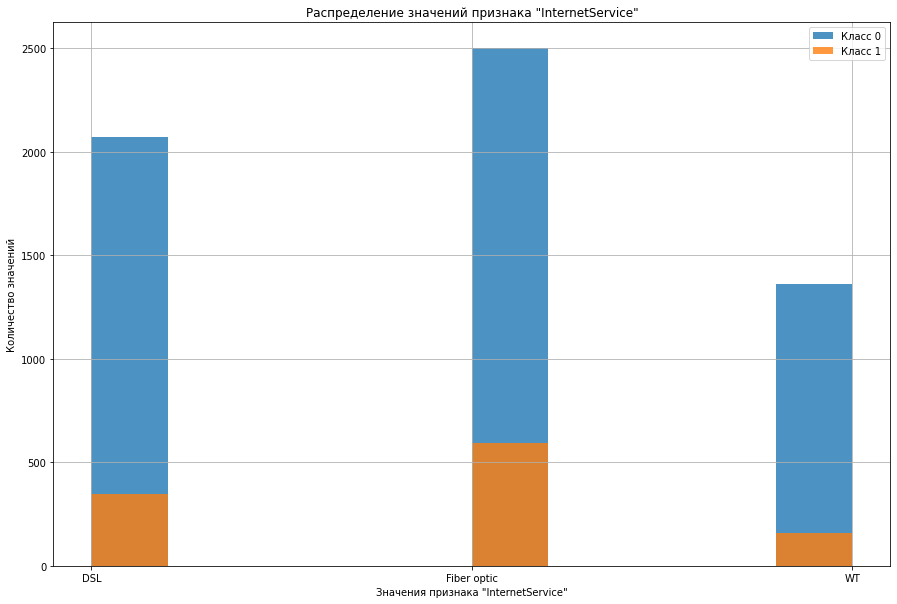

Распределение значений признака "OnlineSecurity"


,count,unique,top,freq
Класс 0,5931,3,No,2971
Класс 1,1101,3,No,526


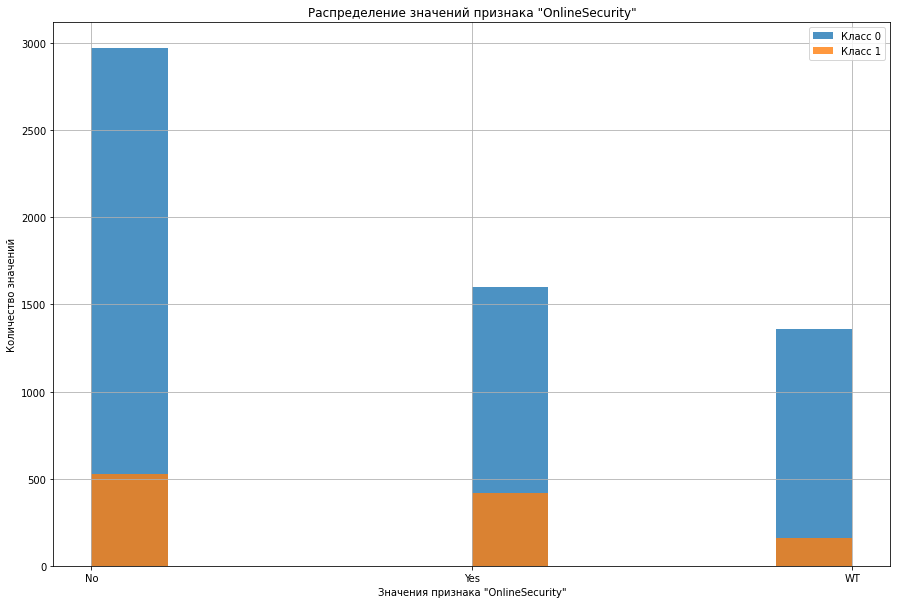

Распределение значений признака "OnlineBackup"


,count,unique,top,freq
Класс 0,5931,3,No,2706
Класс 1,1101,3,Yes,560


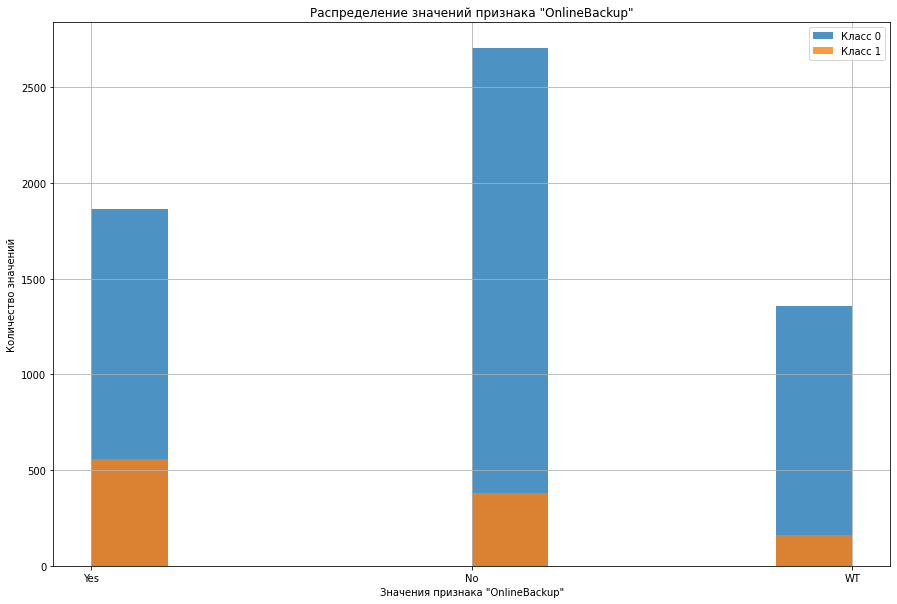

Распределение значений признака "DeviceProtection"


,count,unique,top,freq
Класс 0,5931,3,No,2703
Класс 1,1101,3,Yes,550


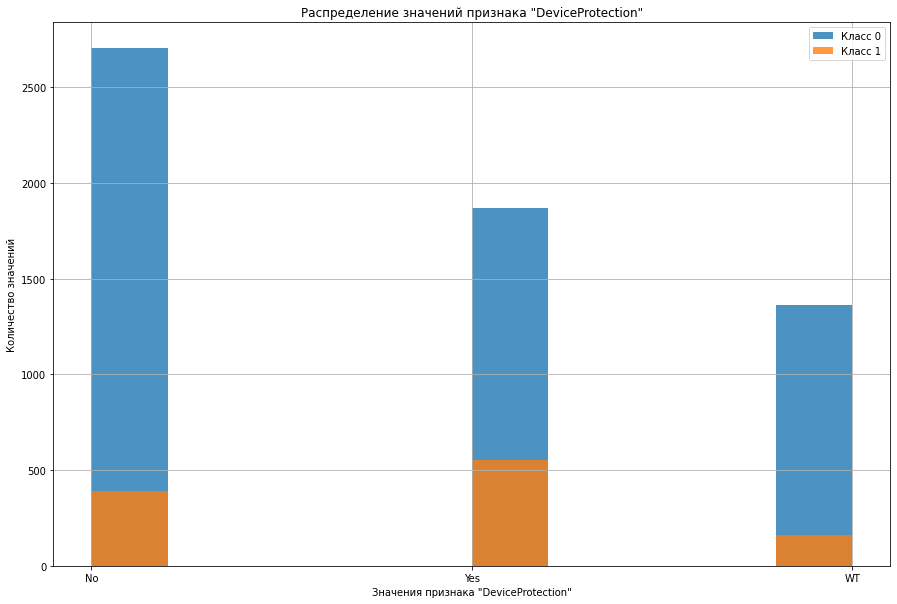

Распределение значений признака "TechSupport"


,count,unique,top,freq
Класс 0,5931,3,No,2929
Класс 1,1101,3,No,543


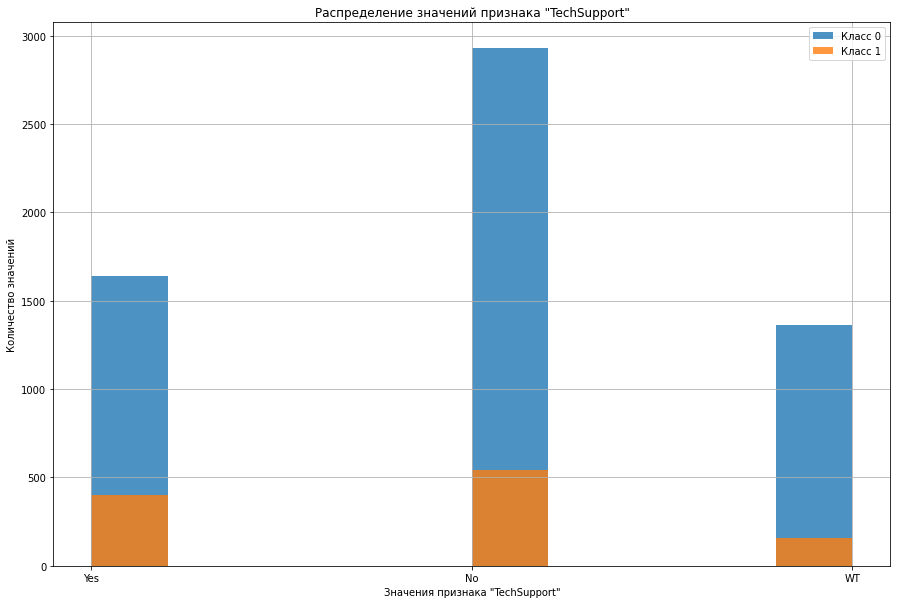

Распределение значений признака "StreamingTV"


,count,unique,top,freq
Класс 0,5931,3,No,2452
Класс 1,1101,3,Yes,584


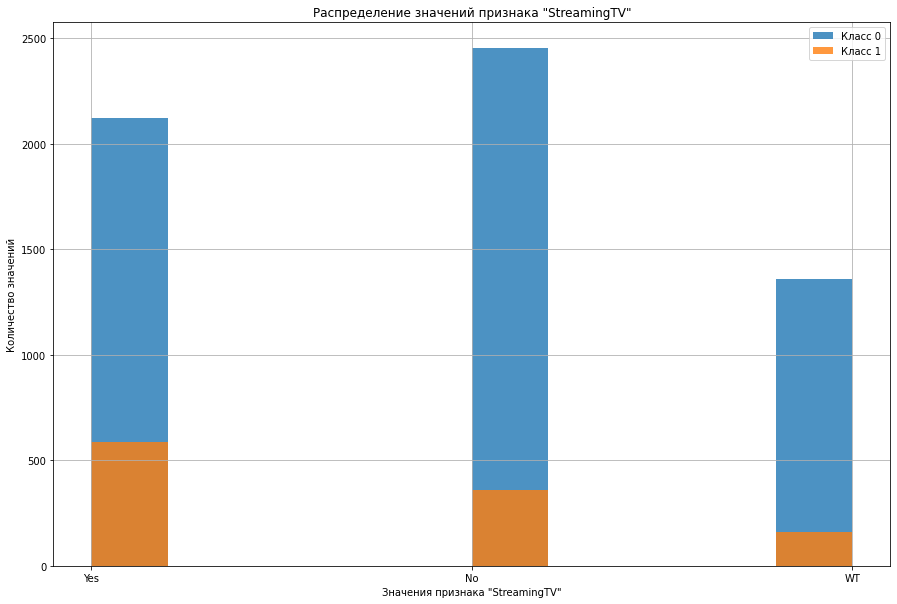

Распределение значений признака "StreamingMovies"


,count,unique,top,freq
Класс 0,5931,3,No,2446
Класс 1,1101,3,Yes,606


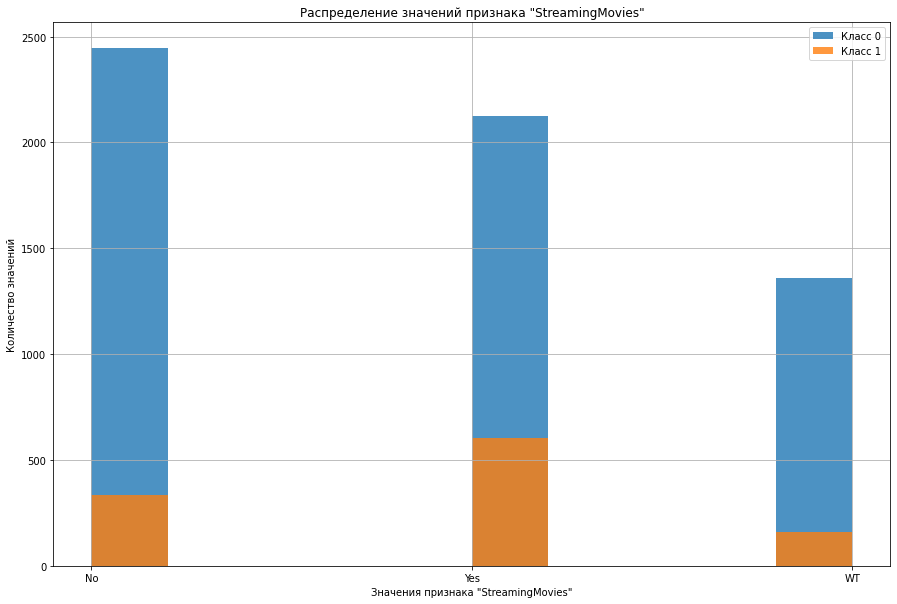

Распределение значений признака "MultipleLines"


,count,unique,top,freq
Класс 0,5931,3,No,3065
Класс 1,1101,3,Yes,678


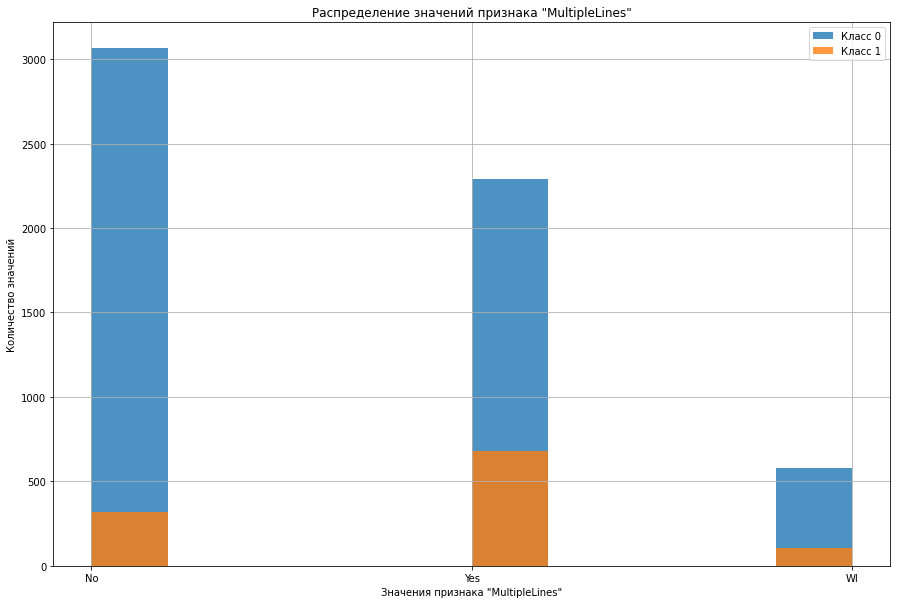

Распределение значений признака "target"


,count,mean,std,min,25%,50%,75%,max
Класс 0,5931.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Класс 1,1101.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


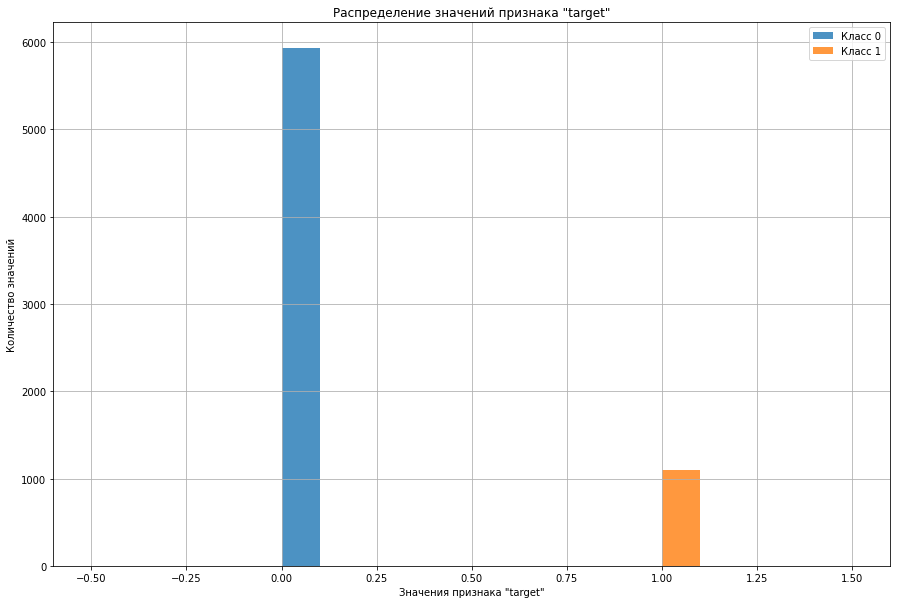

Распределение значений признака "duration_cont"


,count,mean,std,min,25%,50%,75%,max
Класс 0,5931.0,895.338560,716.588322,31.0,245.0,702.0,1523.0,2314.0
Класс 1,1101.0,1615.099001,507.691522,123.0,1279.0,1737.0,2071.0,2253.0


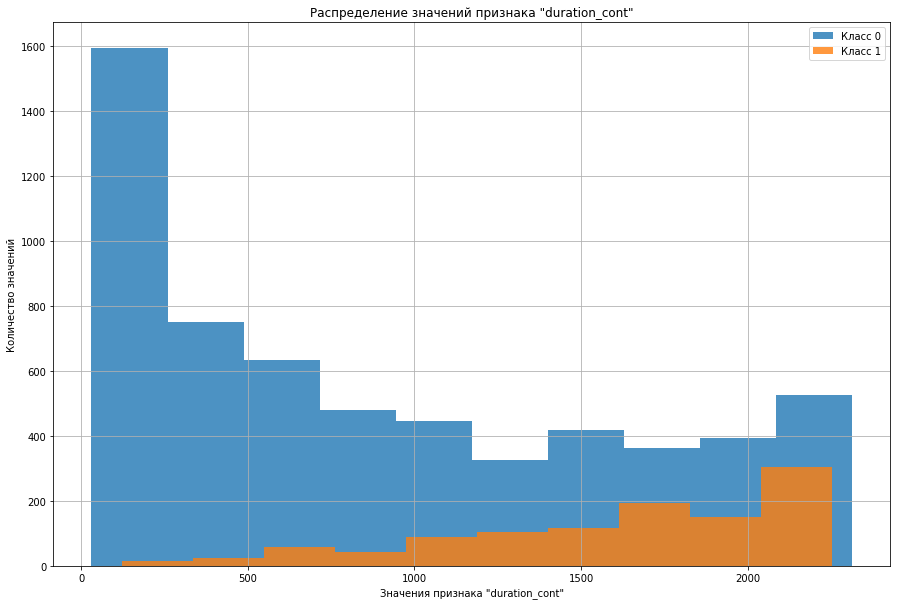

In [17]:
# Конкретные графики:
for i in df.columns:
    for j in df:
        if i == j:
            print(f'Распределение значений признака "{i}"')
                
            t0 = df.loc[df['target'] == 0, i] 
            t1 = df.loc[df['target'] == 1, i] 
                
            t0 = t0.rename('Класс 0') 
            t1 = t1.rename('Класс 1') 
                
            display(pd.DataFrame([t0.describe(), t1.describe()])) 
                
            t0.hist(legend=True, alpha=.8, figsize=(15, 10))
            t1.hist(legend=True, alpha=.8) 
            plt.title(f'Распределение значений признака "{i}"')
            plt.xlabel(f'Значения признака "{i}"')
            plt.ylabel('Количество значений')
            plt.show()

### Промежуточный вывод:
Произведён исследовательский анализ данных - построена матрица корреляции Фи, а также графики зависимостей целевого признака от остальных. Получили следующие результаты:
  - матрица корреляции показала, что многие параметры слабо связаны с целевым признаком, при необходимости их можно будет удалить;
  - уход клиента слабо зависит от типа подписки - во всех случаях количество отмен примерно одинаковое (хотя больше всего клиентов по месячной подписке);
  - зависимость от PaperlessBilling слабая;
  - меньше всего ушло клиентов, у которых чек отправлялся на электронную почту (наверное, меньше беспокойства);
  - клиенты с наименьшими и наибольшими расходами чаще всего отказывались от подписки;
  - чем меньше потратил абонент, тем выше шанс его ухода;
  - пол не играет никакого значения;
  - выход на пенсию также неособо влияет, хотя по общему соотношению в категориях можно сказать, что пенсионеры чаще отказываются от подписки;
  - если есть супруг/супруга, шансы на отказ немного выше;
  - с наличием детей ситуация аналогична выходу на пенсию;
  - тип подключения к интернету явно не влияет;
  - блокировка опасных сайтов аналогично;
  - те, кто пользуются облачным хранилищем, отказывались от подписки чаще;
  - те, кто пользовался антивирусом, отказывались чаще;
  - возможность ТП не влияла на целевой признак;
  - пользователи со стриминговым сервисом отказывались чаще;
  - с фильмами ситуация аналогична (возможно, дело в качестве данных продуктов);
  - абоненты с несколькими линиями подключения телефона отказывались значимо чаще;
  - общее отношение отказавшихся к действующим абонентам примерно 1/6;
  - количество отказников линейно растёт с увеличением продолжительности пользования услугами.

## Подготовка к обучению моделей

Данных для обучения оказалось мало, поэтому итоговый датафрейм разобьём только на тренировочную и тестовую выборки.

In [18]:
# Готовим тренировочную и тестовую выборки:
features = df.drop('target', axis=1)
target = df['target']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size = TEST_SIZE,
                                                                            random_state = RANDOM_STATE)


print(features_train.shape, target_train.shape,
      features_test.shape, target_test.shape)

(5274, 18) (5274,) (1758, 18) (1758,)


## Обучение моделей

По заданию необходимо сравнить между собой как минимум две модели. Ограничений на время обучения нет, что даёт возмодность использовать модели с бустингом. По предыдущим работам понятно, что при отсутствии явной зависимости целевого признака от остальных, бустинг показывает лучшие результаты. Будем использовать LGBMClassifier и CatBoostClassifier.

Поиск гиперпараметров лучшей модели будем определять по GridSearch. Метрика качества - ROC AUC >= 85%.

In [19]:
# Напомним, что из себя представляют данные:
display(features.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration_cont
0,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,276
1,Month-to-month,No,Mailed check,59.9,539.10,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes,276
2,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No,153
3,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,427
4,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,153


Имеем 3 столбца с количественными признаками: MonthlyCharges, TotalCharges и duration_cont. Они нуждаются в обработке, займёмся этим.

In [20]:
# Скалирование количественных признаков:
#num_col = ['MonthlyCharges', 'TotalCharges', 'duration_cont']

#scaler = StandardScaler()

#features_train[num_col] = scaler.fit_transform(features_train[num_col])
#features_test[num_col] = scaler.transform(features_test[num_col])

#display(features_train.head())

Остались только категориальные признаки. При подаче сырых данных модели плохо справляются с ними, поэтому закодируем вручную.

In [21]:
# Табличка для красивого вывода:
result = pd.DataFrame(columns = ['ROC_AUC', 'Precision'])

def res(name, roc_auc, precision):
    result.loc[name, ['ROC_AUC']] = roc_auc
    result.loc[name, ['Precision']] = precision
    return result

In [22]:
# Список столбцов с категориальными данными:
cat_col = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Обработка категориальных признаков для GBM:
features_train_gbm = features_train.copy()
features_test_gbm = features_test.copy()

encoder = OrdinalEncoder()
features_train_gbm[cat_col] = encoder.fit_transform(features_train_gbm[cat_col])
features_test_gbm[cat_col] = encoder.transform(features_test_gbm[cat_col])

display(features_train_gbm.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration_cont
6816,2.0,0.0,1.0,109.70,6690.60,0.0,0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2191
2382,2.0,0.0,3.0,79.20,2455.20,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,945
6603,1.0,1.0,1.0,90.65,3897.95,1.0,0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,1310
5822,2.0,1.0,0.0,93.25,6714.00,0.0,0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2191
1971,0.0,1.0,3.0,59.55,59.55,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,31


In [23]:
# Обучение GBM:
gbm = LGBMClassifier(random_state = RANDOM_STATE)
gbm_params = {'max_depth': np.arange(4, 11), 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1]}

grid_gbm = GridSearchCV(gbm, 
                    gbm_params, 
                    cv = 3,
                    scoring={'roc_auc': 'roc_auc', 'precision': make_scorer(precision_score, average='binary', zero_division=1)},
                    refit = 'roc_auc').fit(features_train_gbm, target_train)

print('Лучшие параметры модели:', grid_gbm.best_params_)

Лучшие параметры модели: {'learning_rate': 0.1, 'max_depth': 9}


In [24]:
# Занесём результаты в табличку:
results = pd.DataFrame.from_dict(grid_gbm.cv_results_)
best_idx = results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = results.loc[best_idx, 'mean_test_roc_auc']
pr = results.loc[best_idx, 'mean_test_precision']

res('LGBMClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
LGBMClassifier,0.9587,0.9847


In [25]:
pd.DataFrame.iteritems = pd.DataFrame.items

In [26]:
# Обучение CatBoost:
cbr = CatBoostClassifier(random_state = RANDOM_STATE, logging_level='Silent', loss_function='Logloss')
cbr_params = {'max_depth': np.arange(4, 11), 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1], 'iterations': [500,1000,1500,2000]}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring=['roc_auc', 'precision'], refit = 'roc_auc')

grid_cbr.fit(features_train_gbm, target_train)

print('Лучшие параметры модели:', grid_cbr.best_params_)

Лучшие параметры модели: {'iterations': 500, 'learning_rate': 0.1, 'max_depth': 4}


In [27]:
# Занесём результаты в табличку:
results = pd.DataFrame.from_dict(grid_cbr.cv_results_)
best_idx = results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = results.loc[best_idx, 'mean_test_roc_auc']
pr = results.loc[best_idx, 'mean_test_precision']

res('CatBoostClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
LGBMClassifier,0.9587,0.9847
CatBoostClassifier,0.9634,0.9939


### Промежуточный вывод:
В ходе работы были обучены 2 модели машинного обучения: LGBMClassifier и CatBoostClassifier. Обе модели с бустингом, так как скорость нам не важна, а данных мало, поэтому точность приветствуется.

Вторая показала лучший результат при следующих параметрах: . Используем CatBoostClassifier для тестов.

## Тестирование лучшей модели

Теперь обучим модель CatBoostClassifier на лучших параметрах и предскажем результаты по тестовой выборке.

In [34]:
# Обучение лучшей модели:
model = CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           iterations = 500, 
                           learning_rate = 0.1, 
                           max_depth = 4,
                           random_state = RANDOM_STATE).fit(features_train_gbm, target_train)
predictions = model.predict(features_test_gbm)

y_pred_proba = model.predict_proba(features_test_gbm)[:, 1]

In [35]:
# Вычисляем ROC_AUC на тесте:
roc_auc = roc_auc_score(target_test, y_pred_proba)
print('AUC-ROC на тестовом наборе данных:', round(roc_auc, 2))

AUC-ROC на тестовом наборе данных: 0.97


Результат удовлетворяет требованиям (больше или равно 85%).

Изучим влияние всех параметров на предсказания модели, а также построим матрицу ошибок.

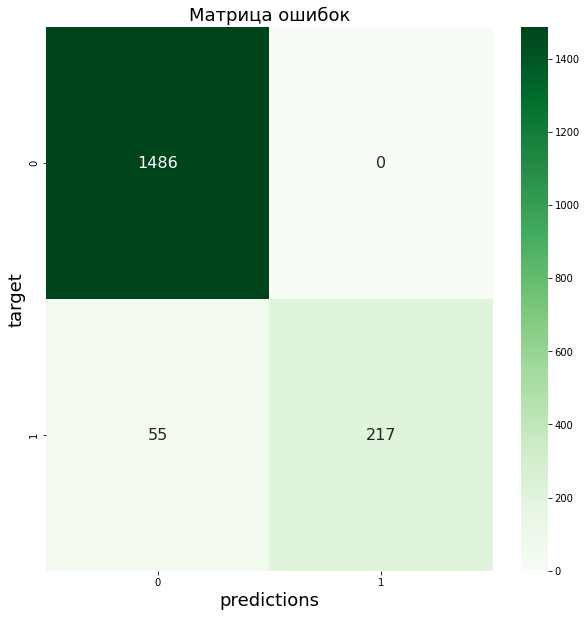

In [36]:
# Матрица ошибок:
cm_cbc = confusion_matrix(target_test, predictions)
cm_cbc_data = pd.DataFrame(cm_cbc, index=['0', '1'], columns=['0', '1'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Greens", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

In [37]:
# Важность признаков:
pd.DataFrame(
    model.feature_importances_, 
    index=features_train.columns.values.tolist(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

,Важность признака
TotalCharges,36.072257
duration_cont,35.959003
MonthlyCharges,20.063620
InternetService,1.294650
PaymentMethod,0.841206
StreamingMovies,0.835474
StreamingTV,0.616780
Type,0.595774
MultipleLines,0.584734
TechSupport,0.557385


### Промежуточный вывод:
Результат предсказаний на тестовой выборке оказался удовлетворительным (ROC_AUC = 97%).

Построили матрицу ошибок и исследовали важность признаков. Результаты следующие:
  - модель плохо справляется с предсказанием расторжения договора, логичнее будет использовать её для прогнозтирования тех, кто точно останется;
  - "пальму первенства" среди признаков делят продолжительность оказания услуг и траты на них.

## Итоговый вывод:
Для работы было получено 4 файла с информацией о клиентах телекома.

Загрузили исходные файлы с данными; пропусков в них не обнаружено, однако сразу столкнулись с проблемой нехватки информации по некоторым пользователям. Придётся серьёзно урезать количество данных.

Произведена предобработка данных, в ходе которой были совершены следующие действия:
  - объединены исходные датафреймы;
  - произведена проверка на дубликаты;
  - обработаны типы данных;
  - заполнены пропуски;
  - добавлены новые признаки;
  - удалены лишние столбцы.

Произведён исследовательский анализ данных - построена матрица корреляции Фи, а также графики зависимостей целевого признака от остальных. Получили следующие результаты:
  - матрица корреляции показала, что многие параметры слабо связаны с целевым признаком, при необходимости их можно будет удалить;
  - уход клиента слабо зависит от типа подписки - во всех случаях количество отмен примерно одинаковое (хотя больше всего клиентов по месячной подписке);
  - зависимость от PaperlessBilling слабая;
  - меньше всего ушло клиентов, у которых чек отправлялся на электронную почту (наверное, меньше беспокойства);
  - клиенты с наименьшими и наибольшими расходами чаще всего отказывались от подписки;
  - чем меньше потратил абонент, тем выше шанс его ухода;
  - пол не играет никакого значения;
  - выход на пенсию также неособо влияет, хотя по общему соотношению в категориях можно сказать, что пенсионеры чаще отказываются от подписки;
  - если есть супруг/супруга, шансы на отказ немного выше;
  - с наличием детей ситуация аналогична выходу на пенсию;
  - тип подключения к интернету явно не влияет;
  - блокировка опасных сайтов аналогично;
  - те, кто пользуются облачным хранилищем, отказывались от подписки чаще;
  - те, кто пользовался антивирусом, отказывались чаще;
  - возможность ТП не влияла на целевой признак;
  - пользователи со стриминговым сервисом отказывались чаще;
  - с фильмами ситуация аналогична (возможно, дело в качестве данных продуктов);
  - абоненты с несколькими линиями подключения телефона отказывались значимо чаще;
  - общее отношение отказавшихся к действующим абонентам примерно 1/6;
  - количество отказников линейно растёт с увеличением продолжительности пользования услугами.
  
В ходе работы были обучены 2 модели машинного обучения: LGBMClassifier и CatBoostClassifier. Обе модели с бустингом, так как скорость нам не важна, а данных мало, поэтому точность приветствуется.

Вторая показала лучший результат при следующих параметрах: . Используем CatBoostClassifier для тестов.

Результат предсказаний на тестовой выборке оказался удовлетворительным (ROC_AUC = 97%).

Построили матрицу ошибок и исследовали важность признаков. Результаты следующие:
  - модель плохо справляется с предсказанием расторжения договора, логичнее будет использовать её для прогнозтирования тех, кто точно останется;
  - "пальму первенства" среди признаков делят продолжительность оказания услуг и траты на них.
  
Работа выполнена в полном объёме, необходимый результат достигнут. Однако бизнессу можно посоветовать придумать новые признаки для категоризации пользователей, так как нынешняя модель в значительной степени ошибается с предсказанием ухода.